In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

import torch
from torch import nn
import torch_geometric as pyg
from torchmetrics import F1Score

# Shape

In [11]:
shape = ShapeDataset(seed=12345)
k_fold = 10
train_data = shape[len(shape)//k_fold:]
val_data = shape[:len(shape)//k_fold]
train_loader = pyg.loader.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = pyg.loader.DataLoader(val_data, batch_size=32, shuffle=False)

In [12]:
shape.describe()

{'mean_n': 30.1455,
 'mean_m': 71.81625,
 'std_n': 16.350529953185003,
 'std_m': 66.97280967629699}

# Train Model

In [62]:
model = GCNClassifier(node_features=len(shape.NODE_CLS),
                      num_classes=len(shape.GRAPH_CLS),
    hidden_channels=64,
    num_layers=4)

In [63]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [64]:
def train():
    model.train()
    losses = []
    for batch in tqdm(train_loader, position=1, leave=False, disable=True):
        model.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out['logits'], batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test(loader):
    f1 = F1Score(task="multiclass", num_classes=len(motif.GRAPH_CLS), average=None)
    model.eval()
    for batch in tqdm(loader, position=1, leave=False, disable=True):
        f1(model(batch)['logits'], batch.y)
    return dict(zip(shape.GRAPH_CLS.values(), f1.compute().tolist()))

@torch.no_grad()
def gt_score():
    batch = pyg.data.Batch.from_data_list([shape.motifs[1]])
    neg, pos = model(batch).mean(dim=0).numpy()
    return neg, pos

In [ ]:
for epoch in trange(16, position=0, leave=True, disable=True):
    train_loss = train()
    train_acc = test(train_loader)
    test_acc = test(val_loader)
    # neg, pos = gt_score()
    print(
        f'Epoch: {epoch:03d}, '
        f'Train Loss: {train_loss:.4f}, '
        f'Train Acc: {train_acc}, '
        f'Test Acc: {test_acc}, '
        # f'GT Pos Score: {pos:.4f}, '
        # f'GT Neg Score: {neg:.4f}, '
    )

In [66]:
# torch.save(model.state_dict(), 'shape_gnn_64x4.pt')
model.load_state_dict(torch.load('shape_simple_gcn.pt'))

<All keys matched successfully>

In [68]:
test(train_loader)

{'random': 0.9495508074760437,
 'lollipop': 0.9366196990013123,
 'wheel': 0.9874301552772522,
 'grid': 0.9427810907363892,
 'star': 1.0}

In [69]:
test(val_loader)

{'random': 0.9383561611175537,
 'lollipop': 0.921135663986206,
 'wheel': 0.988950252532959,
 'grid': 0.9296635985374451,
 'star': 1.0}

# Generate Average Embedding

In [70]:
embeds = [[] for _ in range(len(shape.GRAPH_CLS))]
with torch.no_grad():
    for data in tqdm(shape):
        embeds[data.y.item()].append(model.eval()(pyg.data.Batch.from_data_list([data]))["embeds"].numpy())
mean_embeds = [torch.tensor(np.concatenate(e).mean(axis=0)) for e in embeds]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [71]:
trainer = {}
sampler = {}

# 1

In [97]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=0), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=15), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=shape,
                  k_samples=16)

In [98]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [99]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [100]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=23 m=23
logits=[-6.060784816741943, 3.4627106189727783, -39.373130798339844, 0.3638724088668823, -79.00065612792969]
probs=[6.995351577643305e-05, 0.9567779302597046, 2.384741543462948e-19, 0.043152179569005966, 1.4703724789501891e-36]


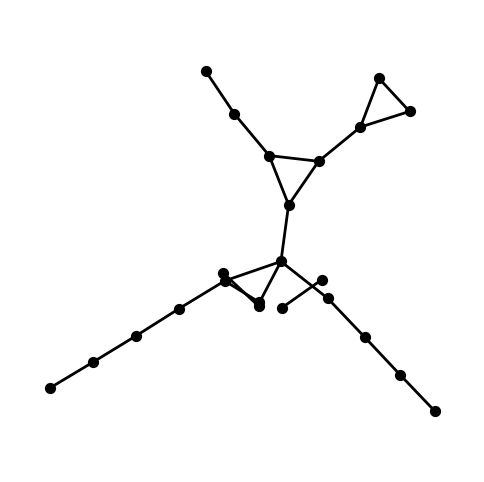

In [101]:
G = trainer[classes].evaluate(threshold=0.5, show=True)
plt.show()

# 2

In [143]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    num_node_cls=len(shape.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=True)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=0), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=shape,
                           k_samples=16)

In [112]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [113]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [114]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=19 m=26
logits=[5.28969144821167, -8.220245361328125, 10.623064994812012, -45.418338775634766, -14.164005279541016]
probs=[0.004804560914635658, 6.521721829244598e-09, 0.9951954483985901, 4.564945280630282e-25, 1.7100945659542788e-11]


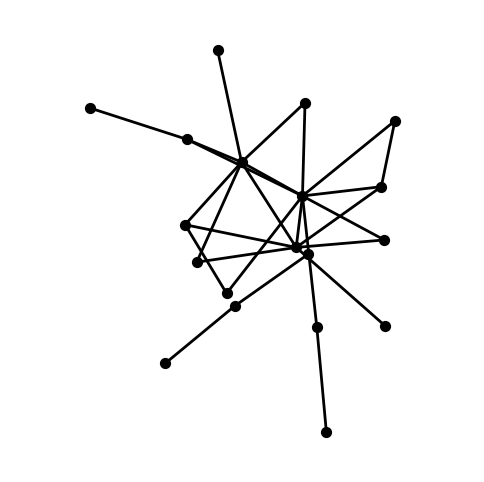

In [115]:
trainer[2].evaluate(threshold=0.5, show=True)

n=20 m=27
logits=[5.091750621795654, -6.341153144836426, 7.143924236297607, -39.64129638671875, -17.253948211669922]
probs=[0.11383278667926788, 1.233163175129448e-06, 0.8861659169197083, 4.2555106328421786e-21, 2.2472607108525722e-11]


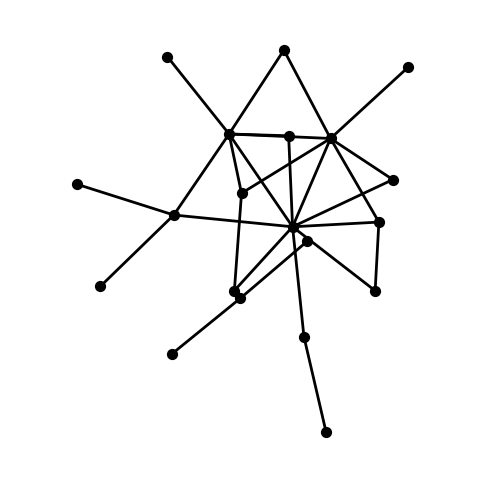

In [116]:
trainer[2].evaluate(bernoulli=True, show=True)

# 3

In [144]:
classes = 3
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    num_node_cls=len(shape.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=10),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=0), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=20), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=shape,
                           k_samples=16)

In [145]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [146]:
trainer[3].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=22 m=20
logits=[-3.935885429382324, 1.1842457056045532, -45.89851760864258, 4.335306167602539, -78.94320678710938]
probs=[0.0002452205226290971, 0.041039444506168365, 1.4635796959082953e-22, 0.9587153792381287, 6.520665058743477e-37]


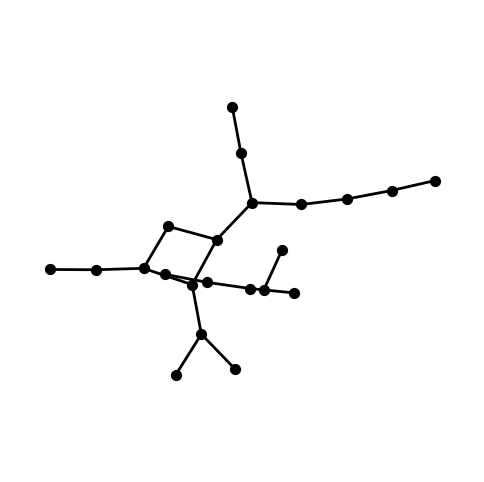

In [147]:
trainer[3].evaluate(threshold=0.5, show=True)

n=25 m=31
logits=[-2.6859655380249023, 0.7950382828712463, -42.267093658447266, 2.3351964950561523, -76.70035552978516]
probs=[0.005403078161180019, 0.17555855214595795, 3.489597123374194e-20, 0.8190383315086365, 3.877927738742028e-35]


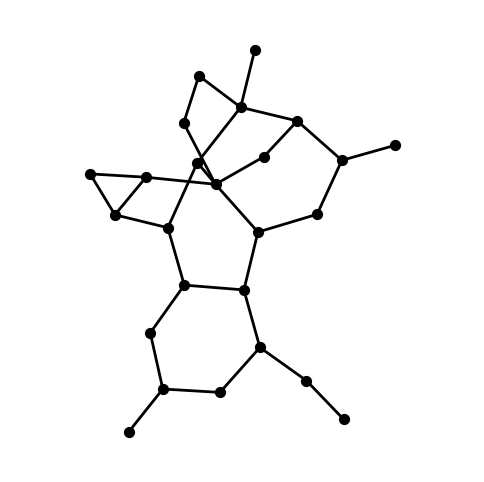

In [148]:
trainer[3].evaluate(bernoulli=True, show=True)

# 4

In [149]:
classes = 4
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    num_node_cls=len(shape.NODE_CLS),
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=0), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=shape,
                           k_samples=16)

In [150]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [151]:
trainer[4].train(5000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/5000 [00:00<?, ?it/s]

True

n=20 m=30
logits=[-157.11343383789062, -139.97312927246094, -122.244873046875, -636.2296142578125, 497.9161376953125]
probs=[0.0, 0.0, 0.0, 0.0, 1.0]


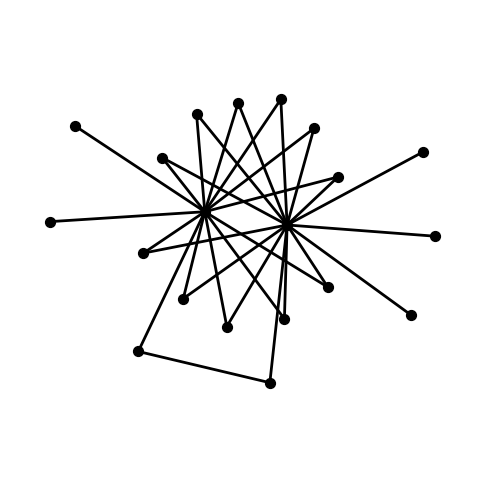

In [152]:
trainer[4].evaluate(threshold=0.5, show=True)

n=20 m=30
logits=[-157.11343383789062, -139.97312927246094, -122.244873046875, -636.2296142578125, 497.9161376953125]
probs=[0.0, 0.0, 0.0, 0.0, 1.0]


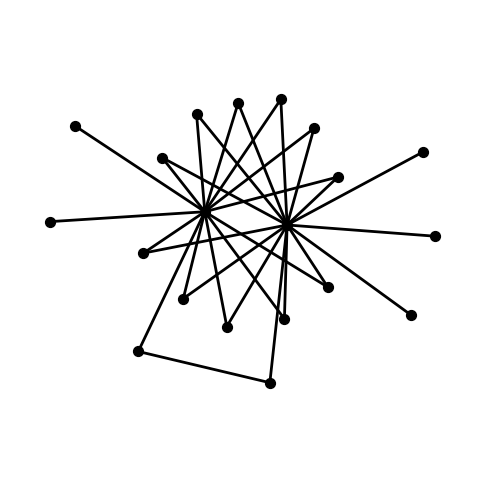

In [153]:
trainer[4].evaluate(bernoulli=True, show=True)